In [25]:
import pandas as pd
import csv
import os
from keras.preprocessing.text import text_to_word_sequence
import pandas as pd
import tensorflow as tf
from keras.preprocessing.text import Tokenizer
import numpy as np
from __future__ import print_function
from keras.preprocessing import sequence
from io import StringIO
import nltk 
from nltk.corpus import stopwords
import re
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer,PorterStemmer
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer 
from sklearn.model_selection import train_test_split

from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.layers import Embedding
from keras.layers import Conv1D, GlobalMaxPooling1D,MaxPooling1D, Bidirectional,LSTM, SpatialDropout1D
!pip install keras-lookahead
from keras_lookahead import Lookahead

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [26]:
#Load the data csv from google drive
review_data = pd.read_csv('/content/tripadvisor_hotel_reviews.csv')
print(review_data.shape)
review_data.head()

(20491, 2)


,Review,Rating
0,nice hotel expensive parking got good deal sta...,4
1,ok nothing special charge diamond member hilto...,2
2,nice rooms not 4* experience hotel monaco seat...,3
3,"unique, great stay, wonderful time hotel monac...",5
4,"great stay great stay, went seahawk game aweso...",5


In [27]:
review_data['Review'].replace(' ', np.nan, inplace=True)
print(review_data['Review'].isnull().sum())
review_data['Rating'].replace(' ', np.nan, inplace=True)
print(review_data['Rating'].isnull().sum())

0
0


In [28]:
review_data.Review[10]

"poor value stayed monaco seattle july, nice hotel priced 100- 150 night not, hotel takes beating quotient, experience simply average, nothing exceptional paying 300+ n't ca n't terribly disappointed, wife stayed nicest suites 200/night felt like overpaying, best advice shop, quality-wise league average marriott nice best western,  "

In [29]:
review_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20491 entries, 0 to 20490
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Review  20491 non-null  object
 1   Rating  20491 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 320.3+ KB


Text preprocessing with general cleaning, stemming and Lemmatizing

In [30]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text. substitute the matched string in REPLACE_BY_SPACE_RE with space.
    text = BAD_SYMBOLS_RE.sub('', text) # remove symbols which are in BAD_SYMBOLS_RE from text. substitute the matched string in BAD_SYMBOLS_RE with nothing. 
    text = text.replace('x', '')
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) 
    return text

review_data['Review'] = review_data['Review'].apply(clean_text)

def getLemmText(text):
 tokens=word_tokenize(text)
 lemmatizer = WordNetLemmatizer()
 tokens=[lemmatizer.lemmatize(word) for word in tokens]
 return ' '.join(tokens)
review_data['Review'] = review_data['Review'].apply(getLemmText)


def getStemmText(text):
    tokens=word_tokenize(text)
    ps = PorterStemmer()
    tokens=[ps.stem(word) for word in tokens]
    return ' '.join(tokens)
review_data['Review'] = review_data['Review'].apply(getStemmText)


In [31]:
review_data.Review[10]

'poor valu stay monaco seattl juli nice hotel price 100 150 night hotel take beat quotient eperi simpli averag noth ecept pay 300+ nt ca nt terribl disappoint wife stay nicest suit 200 night felt like overpay best advic shop qualitywis leagu averag marriott nice best western'

In [32]:
review_data['Rating'].unique()
#5 categories of rating

array([4, 2, 3, 5, 1])

In [33]:
#Tokenize the words, remove the symblos
#Convert the words to integers ising 'text to sequence'
tk = Tokenizer(num_words= 50000, filters = '!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',lower=True, split=" ",)
tk.fit_on_texts(review_data['Review'])
x = tk.texts_to_sequences(review_data['Review'])

In [34]:
#Encoding the integers using pad sequence 
#Adjust the number of words using maxlen based on word frequency 
X = sequence.pad_sequences(x, maxlen=200)

In [35]:
#Y = review_data['Rating'].values
Y = pd.get_dummies(review_data.Rating)

In [36]:
#X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.15)

In [37]:
#Y_train = np.reshape(Y_train, (Y_train.shape[0], 1))
print(X_train.shape, Y_train.shape)

(17417, 200) (17417, 5)


In [38]:
max_features = 50000
filters = 250
hidden_dims = 250
kernel_size = 2
dropout = 0.2

#Let us try using the Lookahead optimiser with Adam as the inner optimiser
opt = tf.keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=1e-6, amsgrad=False)
lk = Lookahead(opt, sync_period=5, slow_step=0.5, name = 'Lookahead')

model = Sequential()
model.add(Embedding(max_features,200,input_length=X_train.shape[1]))
model.add(SpatialDropout1D(0.3))
model.add(Conv1D(128,2, strides=1, padding='valid'))
model.add(MaxPooling1D(2,2))
model.add(Conv1D(256,2, strides=1, padding='valid'))
model.add(MaxPooling1D(2,2))
model.add(Bidirectional(LSTM(100, dropout=dropout)))
model.add(Dropout(0.3))
#model.add(LSTM(250, dropout=dropout))
#model.add(Dropout(0.3))
model.add(Dense(hidden_dims))
model.add(Dropout(0.2))
model.add(Dense(5))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer=lk.optimizer,
              metrics=['accuracy'])
model.summary()
history = model.fit(X_train,Y_train,
          batch_size=32,
          epochs=10,validation_data = (X_test, Y_test)
          )

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 200, 200)          10000000  
_________________________________________________________________
spatial_dropout1d_6 (Spatial (None, 200, 200)          0         
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 199, 128)          51328     
_________________________________________________________________
max_pooling1d_7 (MaxPooling1 (None, 99, 128)           0         
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 98, 256)           65792     
_________________________________________________________________
max_pooling1d_8 (MaxPooling1 (None, 49, 256)           0         
_________________________________________________________________
bidirectional_6 (Bidirection (None, 200)              

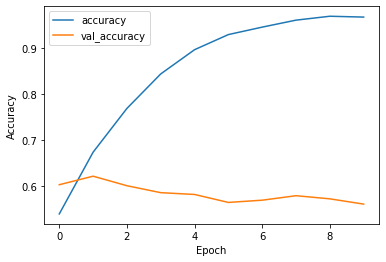

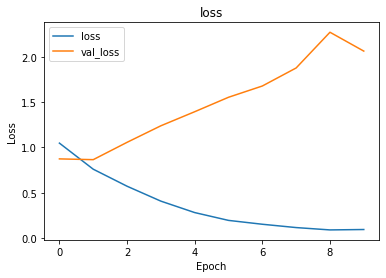

In [39]:
# Accuracy
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Loss
plt.plot(history.history['loss'], label = 'loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.title('loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()